<a href="https://colab.research.google.com/github/leonardosva/mvp_cnh/blob/main/MVP_CNH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Crédito Consignado

- O objetivo principal é criar uma predição para poder conceder crédito consignado as pessoas com matrícula federal. A regrá principal consiste em ser menor que 85 anos de idade, com margem de saldo superior à 35% dos parcelamentos vigentes. Treinaremos modelos de machine learning para o problema de classificação.

**Dataset**

 O dataset possui 5000 instâncias e 8 atributos, com um mix de tipos de dados categóricos e numéricos. Abaixo a descrição das colunas:

Colunas:
- Sexo: sexo do cidadão
- Idade: idade do cidadão
- UF: unidade federativa
- Situação Funcional: Aposentado / Ativo e etc...
- Tipo Contrato: Estável (Aposentadoria estávle) / Não Estável (Cidadão pode perder a aposentadoria ou pensão
- Pmt_Valor: Valor total dos parcelamentos vigentes
- Margem_Saldo: Valor total disponível para cessão de crédito
- Conceder: Classe de saída: 0 - CONCEDER e 1 - NÃO CONCEDER










**Realizar as importações necessárias para o projeto**

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd # para importação do dataset
import numpy as np #
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imblearn.over_sampling import SMOTE # tratamento do balanceamento por Oversampling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # realiza o ajuste de escalonamento
from sklearn.preprocessing import LabelEncoder # para converter variáveis categóticas
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # estratificação dos Kfolds
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # para matriz de confusão
from sklearn.pipeline import Pipeline # para criação dos pipelines
from sklearn.linear_model import LogisticRegression # algorítmo de regressão logistica
from sklearn.tree import DecisionTreeClassifier # algorítmos arvore de classificação
from sklearn.neighbors import KNeighborsClassifier # algorítmos KNN
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVC
from sklearn.ensemble import BaggingClassifier # ensemble Bagging
from sklearn.ensemble import RandomForestClassifier # ensemble RF
from sklearn.ensemble import ExtraTreesClassifier # ensemble ExtraTree
from sklearn.ensemble import VotingClassifier # ensemblre Voting
from sklearn.ensemble import AdaBoostClassifier # ensembel ADA Boost
from sklearn.ensemble import GradientBoostingClassifier # ensemble GradientBoost
from sklearn.ensemble import HistGradientBoostingClassifier # ensemble GradientBoost
from statistics import mean

**Carregando os dados históricos da base de consignado**

In [9]:
# Carregar os dados

url = "https://raw.githubusercontent.com/leonardosva/mvp_cnh/main/base_cnh_mvp.csv"
data_cnh = pd.read_csv(url, delimiter=',') # leitura do dataset consignado
data_cnh.head() # exibição das 5 primeiras linhas do dataset

,IDADE,CAR_STR_ID_CATEGORIA,CAR_STR_ID_TIPO,CAR_DAT_DT_EMISSAO,CAR_DAT_DT_VALIDADE,RENOVACAO
0,40,AB,C,26/01/2022,09/12/2031,1
1,26,B,P,25/01/2022,25/01/2023,1
2,36,B,P,25/01/2022,25/01/2023,1
3,32,AB,C,25/01/2022,02/08/2031,1
4,26,AB,P,25/01/2022,25/01/2023,1


**Analisando o dataset em busca de discrepâncias e desbalanceamentos**

In [10]:
# Observando as discrepâncias
data_cnh.describe()

,IDADE,RENOVACAO
count,7000.000000,7000.000000
mean,43.663429,0.571429
std,18.008321,0.494907
min,-25.000000,0.000000
25%,35.000000,0.000000
50%,45.000000,1.000000
75%,55.000000,1.000000
max,74.000000,1.000000


*** Podemos verificar um pequeno desvio em relação a idade, pois é muito pouco provável ter pessoas com 122 anos de idade.**

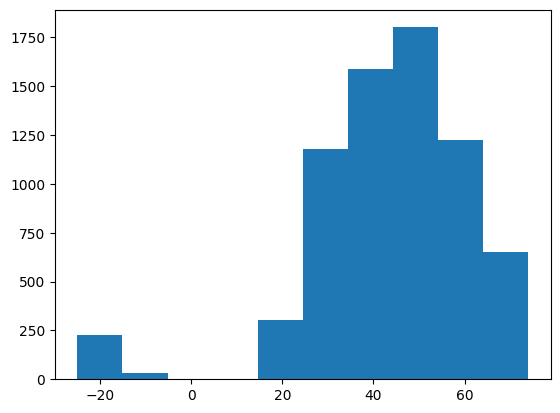

In [11]:
# Plotando a distribuição da idade em relação a base
plt.hist(x=data_cnh['IDADE']);

**Tratamento de valores inconsistentes**
- Após análise dos dados, realizaremos o tratamento de valores inconsistentes. No caso, encontramos algumas idades superiores a 120 anos que podemos considerar pouco prováveis.

In [14]:
# Filtragem das idades superiores à 120
data_cnh[data_cnh['IDADE'] <= 0]

,IDADE,CAR_STR_ID_CATEGORIA,CAR_STR_ID_TIPO,CAR_DAT_DT_EMISSAO,CAR_DAT_DT_VALIDADE,RENOVACAO
14,-15,B,C,29/01/2022,28/12/2024,1
16,-24,B,C,26/01/2022,23/12/2024,1
75,-21,B,C,26/01/2022,04/01/2025,1
76,-22,B,C,26/01/2022,29/12/2024,1
90,-14,B,C,26/01/2022,04/01/2025,1
...,...,...,...,...,...,...
6774,-24,E,C,23/03/2022,10/02/2025,0
6804,-22,D,C,24/03/2022,07/03/2025,0
6895,-25,D,C,01/04/2022,07/03/2025,0
6941,-25,D,C,30/03/2022,20/01/2025,0


In [15]:
# Utilizaremos a idade média para correção sem considerar os dados errados
#data_cnh['idade'][data_cnh['idade'] <= 120].mean()
drop = data_cnh[data_cnh['IDADE']<0].index
data_cnh = data_cnh.drop(drop,axis=0)

In [17]:
data_cnh

,IDADE,CAR_STR_ID_CATEGORIA,CAR_STR_ID_TIPO,CAR_DAT_DT_EMISSAO,CAR_DAT_DT_VALIDADE,RENOVACAO
0,40,AB,C,26/01/2022,09/12/2031,1
1,26,B,P,25/01/2022,25/01/2023,1
2,36,B,P,25/01/2022,25/01/2023,1
3,32,AB,C,25/01/2022,02/08/2031,1
4,26,AB,P,25/01/2022,25/01/2023,1
...,...,...,...,...,...,...
6995,48,D,C,04/04/2022,26/02/2032,0
6996,47,E,C,04/04/2022,22/02/2032,0
6997,59,D,C,04/04/2022,10/03/2027,0
6998,58,D,C,01/04/2022,19/03/2027,0


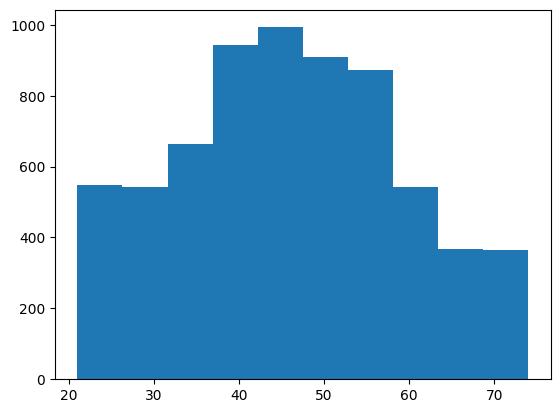

In [16]:
# Plotando a distribuição da idade em relação a base após a correção
plt.hist(x=data_cnh['IDADE']);

**Tratamento de valores faltantes (Não encontrado)**

In [18]:
# Buscar null em todos os registros
data_cnh.isnull().sum()

IDADE                   0
CAR_STR_ID_CATEGORIA    0
CAR_STR_ID_TIPO         0
CAR_DAT_DT_EMISSAO      0
CAR_DAT_DT_VALIDADE     0
RENOVACAO               0
dtype: int64

**Análise de balanceamento por Oversampling**

In [19]:
# Funcão para contar os valores únicos da coluna "conceder" e verificar o balanceamento
np.unique(data_cnh['RENOVACAO'], return_counts=True)

(array([0, 1]), array([2932, 3813]))

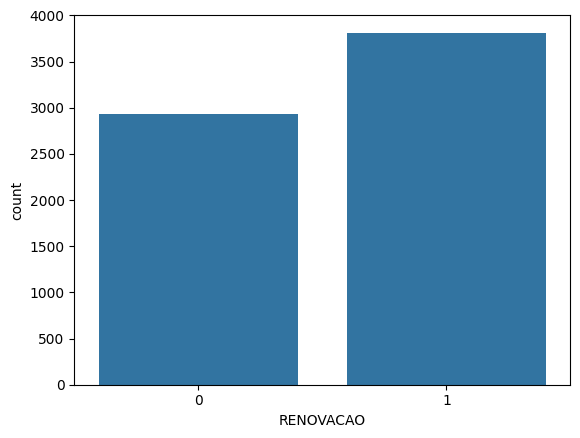

In [20]:
# Plotando em gráfico o balanceamento
sns.countplot(x=data_cnh['RENOVACAO']);

In [25]:
# Dividir entre previsores e classes
X_cnh = data_cnh.drop('RENOVACAO', axis=1)
y_cnh = data_cnh[['RENOVACAO']]

# Codificar variáveis categóricas
label_encoder_tipo = LabelEncoder()
label_encoder_cat = LabelEncoder()
label_encoder_emissao = LabelEncoder()
label_encoder_validade = LabelEncoder()

X_cnh.iloc[:,1] = label_encoder_tipo.fit_transform(X_cnh.iloc[:,1])
X_cnh.iloc[:,2] = label_encoder_cat.fit_transform(X_cnh.iloc[:,2])
X_cnh.iloc[:,3] = label_encoder_emissao.fit_transform(X_cnh.iloc[:,3])
X_cnh.iloc[:,4] = label_encoder_validade.fit_transform(X_cnh.iloc[:,4])

# Holdout
X_cnh_training, X_cnh_test, y_cnh_training, y_cnh_test = train_test_split(X_cnh, y_cnh)


In [26]:
# Funcão para validação cruzada
def cross_validation(model, X_cnh, y_cnh, oversampling=False):
    kfold = KFold(n_splits=10)

    # lista de acurácias de cada split
    accuracy_split = []

    for idx,(idx_training, idx_validation) in enumerate(kfold.split(X_cnh)):
        X_split_training = X_cnh.iloc[idx_training,:]
        y_split_training = y_cnh.iloc[idx_training,:]

        # oversampling, só no split de treino!
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_training, y_split_training = sm.fit_resample(X_split_training, y_split_training)

        # Treinando o modelo
        model.fit(X_split_training, y_split_training.values.flatten())

        X_split_validation = X_cnh.iloc[idx_validation, :]
        y_split_validation = y_cnh.iloc[idx_validation, :]

        # Validação SEM oversampling
        predict_validation = model.predict(X_split_validation)

        acuracia_split = accuracy_score(y_split_validation, predict_validation)

        accuracy_split.append(acuracia_split)

        print(f'Acurácia do split {idx}: {accuracy_split}')
    return accuracy_split

In [27]:
# Criando o modelo
model_hgb = HistGradientBoostingClassifier()

mean_accuracy_with_smote = mean(cross_validation(model_hgb, X_cnh_training, y_cnh_training, oversampling=False))
mean_accuracy_no_smote = mean(cross_validation(model_hgb, X_cnh_training, y_cnh_training, oversampling=True))

f'No smote: {mean_accuracy_no_smote:.02f}, with_smo: {mean_accuracy_with_smote:.02f}'

Acurácia do split 0: [0.9901185770750988]
Acurácia do split 1: [0.9901185770750988, 0.9841897233201581]
Acurácia do split 2: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395]
Acurácia do split 3: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395, 0.9920948616600791]
Acurácia do split 4: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395, 0.9920948616600791, 0.9881422924901185]
Acurácia do split 5: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395, 0.9920948616600791, 0.9881422924901185, 0.9940711462450593]
Acurácia do split 6: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395, 0.9920948616600791, 0.9881422924901185, 0.9940711462450593, 0.9960474308300395]
Acurácia do split 7: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395, 0.9920948616600791, 0.9881422924901185, 0.9940711462450593, 0.9960474308300395, 0.9881422924901185]
Acurácia do split 8: [0.9901185770750988, 0.9841897233201581, 0.9960474308300395, 0.9920948616600791, 0.

'No smote: 0.99, with_smo: 0.99'

- Com Oversampling = 0,99
- Sem Oversampling = 0,99

Como podemos notar, não houve ganho aplicando Oversampling. Desta forma, **não iremos utilizá-lo**.

** Importante: realizamos essas análise, apenas em uma base de treinamento isolada.

**Holdout - Divisão das bases em treinamento e teste. No caso, dividiremos a base de treinamento em 75% e teste com 25%.**

In [28]:
# Divisão das bases de treinamento e teste
# Transformando as variáveis para numpy
X_cnh = X_cnh.values
y_cnh = y_cnh.values
X_cnh_training, X_cnh_test, y_cnh_training, y_cnh_test = train_test_split(X_cnh, y_cnh, test_size=0.30, random_state=10) #
X_cnh_training.shape, y_cnh_training.shape # Exibindo a dimensionalidade da base de treinamento

((4721, 5), (4721, 1))

In [29]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=10) # validação cruzada com estratificação

LR: 0.962083 (0.011702)
KNN: 0.864863 (0.012191)
CART: 0.987078 (0.006318)
NB: 0.881806 (0.018724)
SVM: 0.784156 (0.018451)
Bagging: 0.990679 (0.002544)
RF: 0.989832 (0.003115)
ET: 0.988773 (0.003796)
Ada: 0.991950 (0.002967)
GB: 0.993010 (0.003150)
Voting: 0.966107 (0.012027)


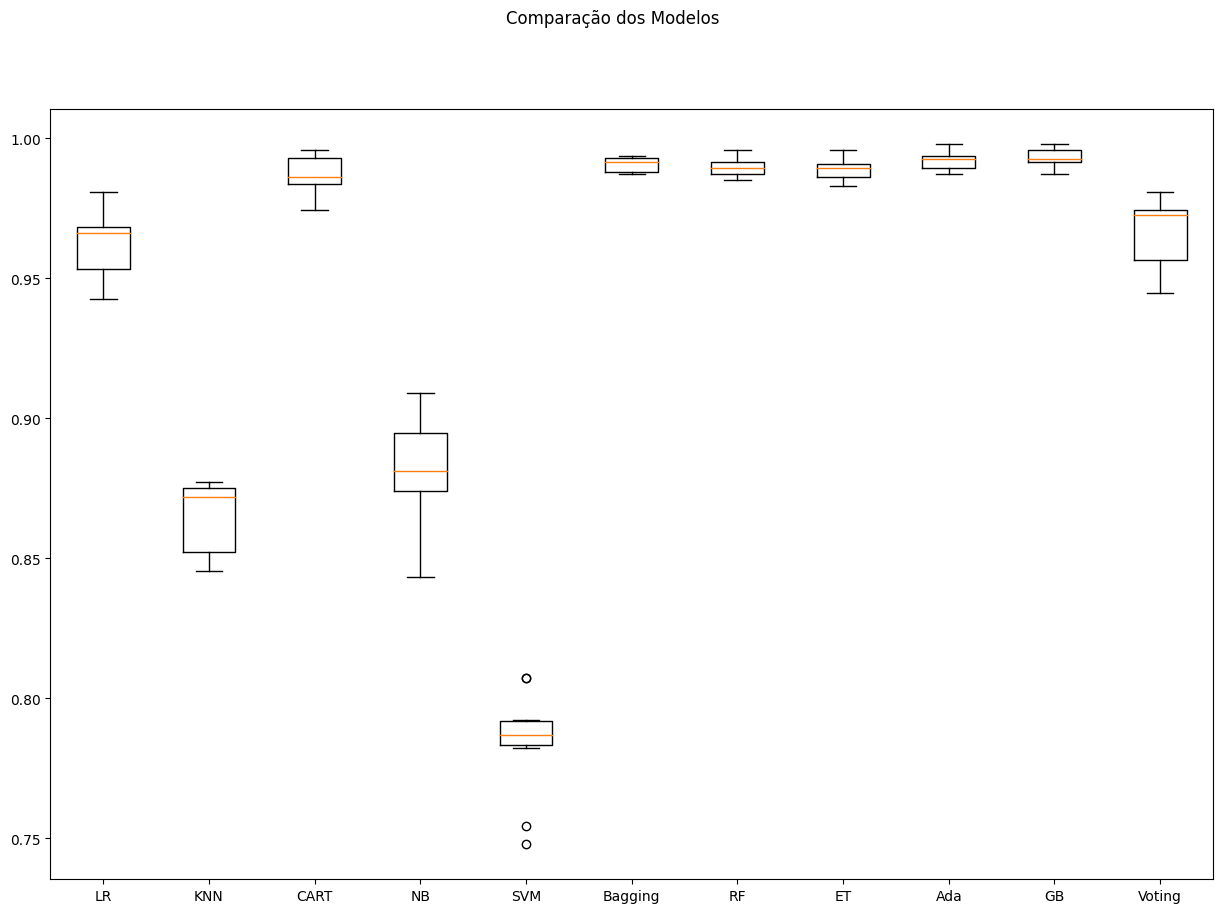

In [30]:
# Modelagem e Inferência
# Criação e avaliação de modelos: linha base
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_cnh_training, y_cnh_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR-orig: 0.962 (0.012)
KNN-orig: 0.865 (0.012)
CART-orig: 0.987 (0.006)
NB-orig: 0.882 (0.019)
SVM-orig: 0.784 (0.018)
Bag-orig: 0.991 (0.003)
RF-orig: 0.990 (0.003)
ET-orig: 0.989 (0.004)
Ada-orig: 0.992 (0.003)
GB-orig: 0.993 (0.003)
Vot-orig: 0.966 (0.012)
LR-padr: 0.962 (0.012)
KNN-padr: 0.966 (0.009)
CART-padr: 0.987 (0.006)
NB-padr: 0.882 (0.019)
SVM-padr: 0.966 (0.011)
Bag-padr: 0.990 (0.003)
RF-padr: 0.990 (0.004)
ET-padr: 0.988 (0.004)
Ada-padr: 0.992 (0.003)
GB-padr: 0.993 (0.003)
Vot-padr: 0.966 (0.011)
LR-norm: 0.950 (0.013)
KNN-norm: 0.966 (0.010)
CART-norm: 0.987 (0.006)
NB-norm: 0.882 (0.019)
SVM-norm: 0.966 (0.012)
Bag-norm: 0.990 (0.003)
RF-norm: 0.989 (0.003)
ET-norm: 0.989 (0.004)
Ada-norm: 0.992 (0.003)
GB-norm: 0.993 (0.003)
Vot-norm: 0.966 (0.011)


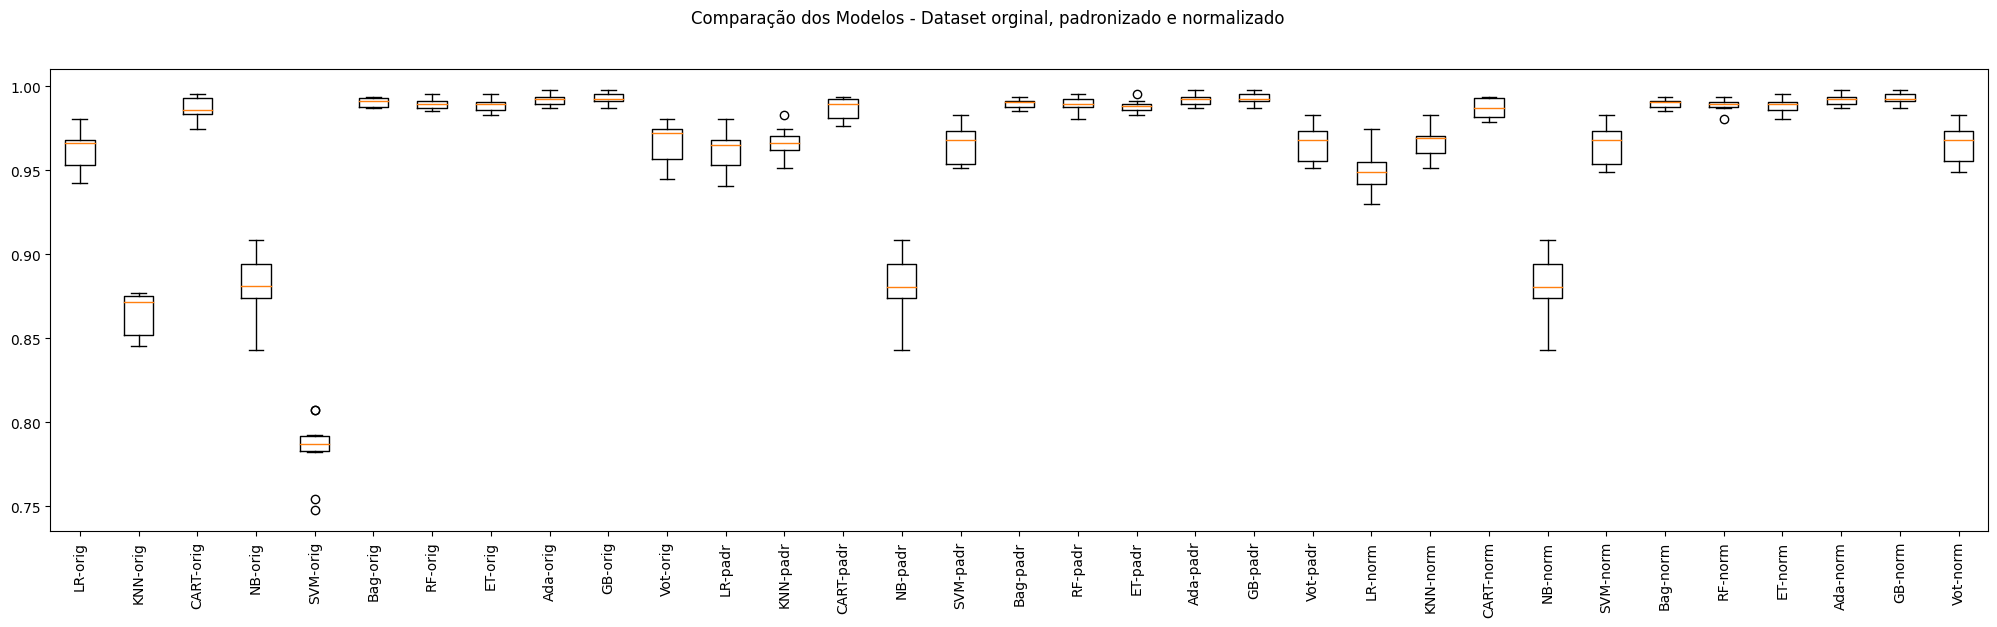

In [31]:
# Criação e avaliação de modelos: dados padronizados e normalizados

np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())



# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_cnh_training, y_cnh_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [33]:
# Otimização dos hiperparâmetros
# Tuning do RandomForestClassifier

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
#random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))


standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('GB-orig', Pipeline(steps=[gradient_boosting])))
pipelines.append(('GB-padr', Pipeline(steps=[standard_scaler, gradient_boosting])))
pipelines.append(('GB-norm', Pipeline(steps=[min_max_scaler, gradient_boosting])))

param_grid = {
    'GB__n_estimators': [50,75,100],
    'GB__loss': ['log_loss', 'deviance', 'exponential', 'log_loss'],
    'GB__criterion': ['friedman_mse', 'squared_error', 'friedman_mse'],
    'GB__max_features': [0.5, 1.0, 1.5],
    #'GB__learning_rate':[0.1, 0.3, 0.5],
    #'GB__min_samples_split':[2, 3, 4, 5],
    #'GB__min_samples_leaf':[1, 2, 3, 4, 5],
    'GB__max_depth':[3, 7, 9, 12, 15],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_cnh_training, y_cnh_training)
    # imprime a melhor configuração
    #print("Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))
    print(name,grid.best_score_,grid.best_params_)

GB-orig 0.9930098183251514 {'GB__criterion': 'friedman_mse', 'GB__loss': 'log_loss', 'GB__max_depth': 3, 'GB__max_features': 1.0, 'GB__n_estimators': 100}
GB-padr 0.9930098183251514 {'GB__criterion': 'friedman_mse', 'GB__loss': 'log_loss', 'GB__max_depth': 3, 'GB__max_features': 1.0, 'GB__n_estimators': 100}
GB-norm 0.9932212348156376 {'GB__criterion': 'friedman_mse', 'GB__loss': 'exponential', 'GB__max_depth': 7, 'GB__max_features': 1.0, 'GB__n_estimators': 100}


In [1]:
# Finalização do Modelo
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_cnh_training) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_cnh_training) # aplicação da padronização no conjunto de treino
#model = RandomForestClassifier(n_estimators=100, max_features=1.0, criterion='log_loss', max_depth=15)
model = GradientBoostingClassifier(n_estimators=100, max_features=1.0, criterion='log_loss', max_depth=15)
model.fit(rescaledX, y_cnh_training)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_cnh_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_cnh_test, predictions))

NameError: name 'StandardScaler' is not defined

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X_cnh) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X_cnh) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y_cnh)

RandomForestClassifier(criterion='log_loss', max_depth=15, max_features=1.0)

In [ ]:
# Matriz de confusão
confusion_matrix(y_cnh_test, predictions)

array([[455,   5],
       [  6, 784]])

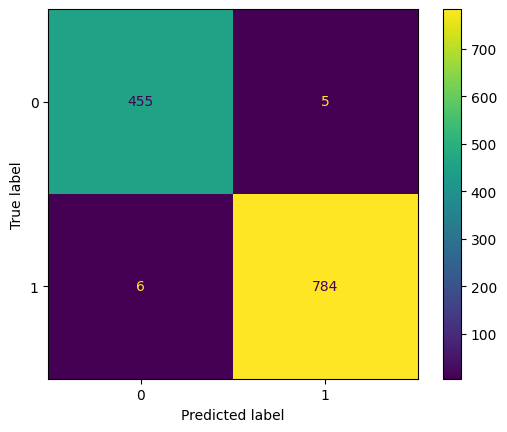

In [ ]:
# Visualizando através do gráfico da matriz de confusão
cm = confusion_matrix(y_cnh_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

**Análise da Matriz de Confusão**

- Verdadeiro Positivo: 454 - Quando o classificador previu SIM (CONCEDER = 0) e a classe correta é SIM (CONCEDER=0)
- Verdadeiro Negativo: 785 - Quando o classificador previu NÂO (CONCEDER = 1) e a classe correta é NÂO (CONCEDER=1)
- Falso Positivo: 6 - Quando o classificador previu SIM (CONCEDER = 0) e a classe correta é NÂO (CONCEDER = 1)
- Falso Negativo: 5 - Quando o classificador previu NÂO (CONCEDER = 1) e a classe correta é SIM (CONCEDER = 0)

Total de Registros: 1250
Taxa de acerto (acurácia): (454 + 785) / 1250 = 0,9912


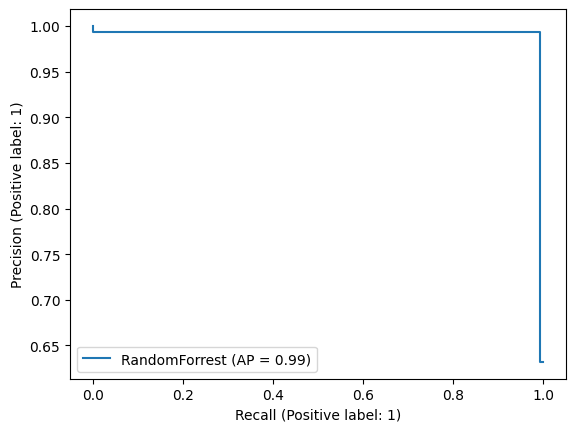

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_cnh_test, predictions, name="RandomForrest")
plt.show()

***Importante: Essa plotagem não permite o aumento de casas decimais!!!***

Análise de Precision e Recall

**Precision**

Quando o modelo previu SIM, o quanto ele estava certo?
- 454 / (454 + 6) = 0,986
- O modelo identifica corretamente 98% para concessão do crédito

**Recall**
- 454 / (454 + 5) = 0,989
- O modelo identifica corretamente 99% de toda base

In [ ]:
# Simulando a aplicação do modelo em dados não vistos
# Novos dados - não sabemos a classe!
data = {'idade': [90, 30, 56],
        'uf': ['RJ', 'BA', 'SP'],
        'situacao_funcional':['ATIVO PERMANENTE','APOSENTADO', 'APOSENTADO'],
        'tipo_contrato': ['ESTAVEL', 'ESTAVEL', 'NAO ESTAVEL'],
        'pmt_valor': [100, 500, 35000],
        'margem_saldo': [200, 5000, 4000],
        }

atributos = ['sexo','idade','uf','situacao_funcional','tipo_contrato', 'pmt_valor', 'margem_saldo']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:7]


# Codificar variáveis categóricas
label_encoder_sex = LabelEncoder()
label_encoder_u = LabelEncoder()
label_encoder_sit_fun = LabelEncoder()
label_encoder_tp_con = LabelEncoder()
X_entrada[:,0] = label_encoder_sex.fit_transform(X_entrada[:,0])
X_entrada[:,2] = label_encoder_u.fit_transform(X_entrada[:,2])
X_entrada[:,3] = label_encoder_sit_fun.fit_transform(X_entrada[:,3])
X_entrada[:,4] = label_encoder_tp_con.fit_transform(X_entrada[:,4])

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-8.08694075e-01  1.37189553e+00 -1.83751337e+00 -1.24936346e+00
  -4.40973600e-01 -7.73886984e-01 -5.06432696e-01]
 [-8.08694075e-01 -1.44826669e+00 -1.97734606e+00 -1.65864193e+00
  -4.40973600e-01 -6.30180789e-01  1.30429089e-01]
 [-8.08694075e-01 -2.26196395e-01 -1.69768069e+00 -1.65864193e+00
   2.26770945e+00  1.17644784e+01 -2.25044957e-03]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1 0 1]


# Conforme saída acima, o modelo "preditou" corretamente os dados não vistos, respeitando a regra de negócio (A regrá principal consiste em ser menor que 85 anos de idade, com margem de saldo superior à 35% dos parcelamentos vigentes), somente o segundo registro está correto.

